# Derive interannual phenology metrics and thier drivers

In [1]:
black=(0,0,0)
lightblue= (112/255.0,160/255.0,205/255.0)
orange=(196/255.0,121/255.0,0)
grey=(178/255.0,178/255.0,178/255.0)
darkblue=(0,52/255.0,102/255.0)
darkgreen=(0,79/255.,0)

black_shade = (128/255.0,128/255.0, 128/255.0)
lightblue_shade = (91/255.0, 174/255.0,178/255.0)
orange_shade = (204/255.0,174/255.0,113/255.0)
grey_shade = (191/255.0,191/255.0,191/255.0)
darkblue_shade = (67/255.0,147/255.0,195/255.0)
darkgreen_shade =(223/255.0, 237/255.0,195/255.0)

yellow = (254/255.0, 204/255.0,92/255.0)
yellow = (225/255.0, 195/255.0,46/255.0)

In [3]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 

warnings. filterwarnings(action) # Climatology

In [4]:
import warnings
warnings.filterwarnings('ignore') 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Load all relevant data

- Gliders
- ARGO floats 4397; 4467
- SATELLITE DATA - SEA ICE CONC (OSI-450 (1997 - 2015) and OSI-430-b))
                 - SEA ICE THICKNESS (Uni Bremen)
                 - PAR (MODIS)
                 - CHLOR-A (OC-CCI)

In [5]:
rootdir = '../data/'

In [6]:
# Gliders 
gl1= xr.open_dataset(rootdir+'/seaglider/sg643/sg643_optics_gridded_29012021.nc')
gl2= xr.open_dataset(rootdir+'/seaglider/sg640/sg640_optics_30012021.nc')
schl_gl1=gl1.chl[:20,:].mean(dim='depth')#.resample(time='1M').mean()
schl_gl2=gl2.chl[:20,:].mean(dim='depth')#.resample(time='1M').mean()


gl2018 = pd.DataFrame({'chla':schl_gl1,
                      'time':gl1.time})

gl2018=gl2018.set_index('time')

gl2019 = pd.DataFrame({'chla':schl_gl2,
                      'time':gl2.time})

gl2019=gl2019.set_index('time')

In [7]:
# corrected argo dat
float4397 = xr.open_dataset('../data/argo/argo4397.nc')
float4467 = xr.open_dataset('../data/argo/argo4467.nc')

float4397['schl']=float4397.chla[:20,:].mean(dim='depth')
float4467['schl']=float4467.chla[:20,:].mean(dim='depth')

overlap4467=float4467.sel(time=slice('2015-01-01','2019-05-01'))
overlap4397=float4397.sel(time=slice('2015-01-01','2019-05-01'))

clim4467=overlap4467.schl.groupby("time.week").mean("time").to_dataframe()
clim4397=overlap4397.schl.groupby("time.week").mean("time").to_dataframe()

clim4467['variance']=overlap4467.schl.groupby("time.week").std("time")
clim4397['variance']=overlap4397.schl.groupby("time.week").std("time")

argoclim = clim4467

argoclim['clim4397_schl']=clim4397['schl']
argoclim['clim4397_var']=clim4397['variance']


In [8]:
floats_mean=np.nanmean(np.vstack([argoclim['schl'],argoclim['clim4397_schl']]),0)

floats_var=np.nanmean(np.vstack([argoclim['clim4397_var'],argoclim['variance']]),0)

In [9]:
floatsclim = pd.DataFrame({'floats_chl':floats_mean,
                          'floats_var':floats_var,
                           'weeks':np.arange(1,54,1)
                         })
floatsclim = floatsclim.set_index('weeks')

In [10]:
weeks_since_float = (((floatsclim.index[:]+ 26) %54)-26)
floatsclim['weeks_since']=weeks_since_float
floatsclim=floatsclim.set_index('weeks_since').sort_values('weeks_since')


In [11]:

# Qnet

qnet1 = xr.open_dataset('../data/era5/qnet1.nc')
qnet2 = xr.open_dataset('../data/era5/qnet2.nc')


qnet=qnet1.msnlwrf+qnet1.msnswrf+qnet2.mslhf+qnet2.msshf
qnet = qnet.sel(latitude=slice(-59,-62),longitude=slice(-10,5)).mean(dim='latitude').mean(dim='longitude').mean(dim='expver')

In [12]:
# SATELLITE DATA (Selected box [-2.5,5; -61,-59])
# Compute climatologies

# CHLOR_A
ds = xr.open_dataset(rootdir+'chl/CCI_ALL-v5.0-8DAY_01.nc')
ds2 = xr.open_dataset(rootdir+'chl/CCI_ALL-v5.0-8DAY_02.nc')
ds3 = xr.open_dataset(rootdir+'chl/CCI_ALL-v5.0-8DAY_03.nc')
sat=xr.concat([ds2,ds,ds3],dim='time')
ds3 = sat.sel(lat=slice(-59,-62),lon=slice(-10,5)).mean(dim='lat').mean(dim='lon')

satchl=ds3

chl_climatology=satchl.chlor_a.groupby("time.week").mean("time").to_dataframe()
chl_climatology['variance']=satchl.chlor_a.groupby("time.week").std("time").to_series()

par = xr.open_dataset('../data/par/par_data.nc')#.to_dataframe()

par_climatology = par.groupby('time.week').mean('time').to_dataframe()
par_climatology['variance'] = par.par.groupby("time.week").std("time").to_series()

# ERA5 WINDS
ds = xr.open_dataset('../data/era5/era5_winds.nc')
era = ds.sel(longitude=slice(-10,5),latitude=slice(-59,-62)).mean(dim='longitude').mean(dim='latitude')

import airsea    
tau_x=airsea.windstress.stress(era.u10,z=10,drag='largepond',rho_air=1.22,Ta=10.)
tau_y=airsea.windstress.stress(era.v10,z=10,drag='largepond',rho_air=1.22,Ta=10.)
era['tau'] = xr.DataArray(data=np.sqrt(tau_x**2+tau_y**2),dims={'time':era.time})

wind_climatology=era.tau.groupby("time.week").mean("time").to_dataframe()
wind_climatology['variance']=era.tau.groupby("time.week").std("time").to_series()

#Qnet CLIM

qnet_clim = pd.DataFrame({'qnet':qnet.groupby("time.week").mean("time").to_series()})
qnet_clim['variance']=qnet.groupby("time.week").std("time").to_series()

# SEA ICE CONCENTRATION
ds  = xr.open_dataset('../data/seaice/seaice_subset.nc')
si_ds=ds.sel(longitude=slice(-10,5),latitude=slice(-62,-59)).mean(dim='longitude').mean(dim='latitude')

ice_climatology=si_ds.ice_conc.groupby("time.week").mean("time").to_dataframe()
ice_climatology['variance']=si_ds.ice_conc.groupby("time.week").std("time").to_series()


In [13]:
time_index=si_ds.ice_conc.resample(time='1W').mean("time")

In [14]:
month_index = time_index.sel(time=slice('2018-07-01','2019-06-30'))

In [15]:
weeks_since=(((chl_climatology.index[:]+ 26) %54)-26)
weeks_since_par =(((par_climatology.index[:]+ 26) %54)-26)
weeks_since_float = (((floatsclim.index[:]+ 26) %54)-26)

chl_climatology['weeks_since']=weeks_since

wind_climatology['weeks_since']=weeks_since
qnet_clim['weeks_since']=weeks_since

ice_climatology['weeks_since']=weeks_since
par_climatology['weeks_since']=weeks_since_par

chl_climatology=chl_climatology.set_index('weeks_since').sort_values('weeks_since')
ice_climatology=ice_climatology.set_index('weeks_since').sort_values('weeks_since')
wind_climatology=wind_climatology.set_index('weeks_since').sort_values('weeks_since')
par_climatology=par_climatology.set_index('weeks_since').sort_values('weeks_since')
qnet_clim=qnet_clim.set_index('weeks_since').sort_values('weeks_since')

chl_climatology['month_index']=month_index.time


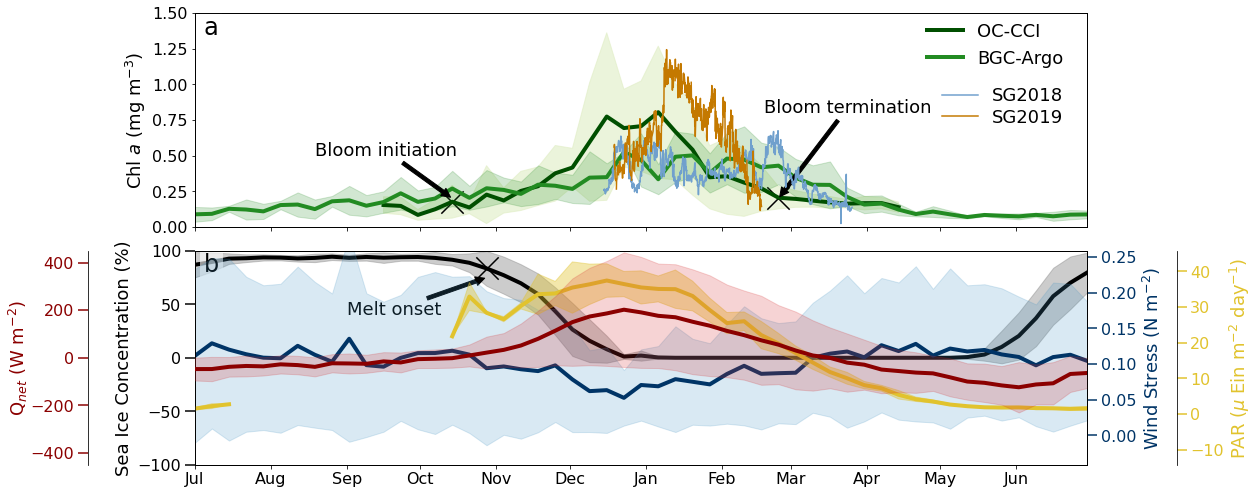

In [18]:
import matplotlib 
import datetime
import seaborn as sns
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams.update({'font.size': 18})

import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=[16,14],constrained_layout=True)
gs = gridspec.GridSpec(3, 3,wspace=0.4,hspace=0.1,height_ratios =(0.3,0.3,0.4))


maxchl = chl_climatology.chlor_a.max()
apex_ind = np.array(([chl_climatology.chlor_a==maxchl])).argmax()
prepeak_min = chl_climatology.chlor_a[:apex_ind+1].min()
postpeak_min = chl_climatology.chlor_a[apex_ind:].min()

prepeak_subset = chl_climatology.iloc[0:apex_ind]
postpeak_subset = chl_climatology.iloc[apex_ind:len(chl_climatology.chlor_a)]

initiation = prepeak_subset.index[np.abs(prepeak_subset.chlor_a-(prepeak_min+(0.12*(maxchl-prepeak_min)))).argmin()]
termination = postpeak_subset.index[np.abs(postpeak_subset.chlor_a-(postpeak_min+(0.1*(maxchl-postpeak_min)))).argmin()]

axes2 = plt.subplot(gs[0, :])

axes2.plot(chl_climatology.month_index,chl_climatology.chlor_a,c=darkgreen,lw=4,label='OC-CCI')
axes2.fill_between(chl_climatology.month_index,chl_climatology.chlor_a- chl_climatology.variance, chl_climatology.chlor_a + chl_climatology.variance, alpha=0.6,color=darkgreen_shade) 

axes2.scatter(chl_climatology.month_index.iloc[chl_climatology.index==termination],(chl_climatology.chlor_a).iloc[chl_climatology.index==termination],marker='x',s=500,c='k')
axes2.scatter(chl_climatology.month_index.iloc[chl_climatology.index==initiation],(chl_climatology.chlor_a).iloc[chl_climatology.index==initiation],marker='x',s=500,c='k')

axes2.plot(chl_climatology.month_index,floatsclim.floats_chl,c='forestgreen',lw=4,label='BGC-Argo')
axes2.fill_between(chl_climatology.month_index,floatsclim.floats_chl- floatsclim.floats_var,floatsclim.floats_chl+ floatsclim.floats_var, alpha=0.2,color='forestgreen') 
axes2.annotate("Bloom initiation",
            xy=(chl_climatology.month_index.iloc[chl_climatology.index==initiation], 0.2), xycoords='data',
            xytext=(datetime.date(2018,8,19), 0.5), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3",
                            color='k'
                           ),
            )

axes2.annotate("Bloom termination",
            xy=(chl_climatology.month_index.iloc[chl_climatology.index==termination], 0.2), xycoords='data',
            xytext=(datetime.date(2019,2,18), 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3",
                            color='k'
                           ),
            )


ax4=axes2.twiny()
ax4.plot(gl2018/3,c=lightblue,label='SG2018')
ax4.set_xlim(datetime.date(2018,7,1),datetime.date(2019,6,30))
ax4.set_ylim(0,1.5)
ax4.legend(bbox_to_anchor=(0.001, 0.05, 0.99, .68),frameon=False)


ax5=axes2.twiny()
ax5.plot(gl2019[560:]/3,c=orange,label='SG2019')
ax5.set_xlim(datetime.date(2019,7,1),datetime.date(2020,6,30))
             
ax5.set_ylim(0,1.5)
ax5.legend(bbox_to_anchor=(0.001, 0.05, 0.99, .58),frameon=False)

ax5.set_xticklabels([''])
ax4.set_xticklabels([''])
ax4.set_xticks([''])
ax5.set_xticks([''])

axes2.legend()
axes2.set_xlim(-22,22)
axes2.set_ylim(0,1.5)
axes2.legend(bbox_to_anchor=(0.001, 0.05, 0.99, .98),frameon=False)

axes2.set_xlabel('')

import matplotlib.dates as mdates
  
axes2.xaxis.set_major_locator(mdates.MonthLocator())
axes2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))


axes2.set_xlim(datetime.date(2018,7,1),datetime.date(2019,6,30))

############

ax = plt.subplot(gs[1, :])



max_ice = ice_climatology.ice_conc.max()
max_ind = np.array(([ice_climatology.ice_conc==max_ice])).argmax()
prepeak_subset = ice_climatology.iloc[0:max_ind+1]
postpeak_subset = ice_climatology.iloc[max_ind:len(ice_climatology.ice_conc)]

termination=postpeak_subset.index[(postpeak_subset.ice_conc.values<(0.9*(max_ice)))][0]

ice_climatology.ice_conc[ice_climatology.ice_conc<0]=np.nan

ax.plot(chl_climatology.month_index, ice_climatology.ice_conc,c=black,lw=4)

ax.fill_between(chl_climatology.month_index,ice_climatology.ice_conc- ice_climatology.variance, ice_climatology.ice_conc + ice_climatology.variance, alpha=0.4,color=black_shade) 


ax.scatter(chl_climatology.month_index.iloc[ice_climatology.index==termination],(ice_climatology.ice_conc).iloc[ice_climatology.index==termination],marker='x',s=500,c='k')
ax.annotate("Melt onset",
            xy=(chl_climatology.month_index.iloc[ice_climatology.index==termination], 75), xycoords='data',
            xytext=(datetime.date(2018,9,1), 40), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="arc3",
                            color='k'
                           ),
            )
ax11=ax.twinx()

ax11.plot( chl_climatology.month_index,wind_climatology.tau,c=darkblue,lw=4)
ax11.fill_between(chl_climatology.month_index,wind_climatology.tau- wind_climatology.variance, wind_climatology.tau + wind_climatology.variance, alpha=0.2,color=darkblue_shade) 

# #####################################
ax22 = ax.twinx()
plt.plot(chl_climatology.month_index, par_climatology.par,c=yellow,lw=4)
ax22.fill_between(chl_climatology.month_index,par_climatology.par- par_climatology.variance, par_climatology.par + par_climatology.variance, alpha=0.4,color=yellow) 

ax33 = ax.twinx()
ax33.plot(chl_climatology.month_index,qnet_clim.qnet,c='darkred',lw=4)
ax33.fill_between(chl_climatology.month_index,qnet_clim.qnet- qnet_clim.variance,qnet_clim.qnet + qnet_clim.variance, alpha=0.2,color="tab:red") 

# #######################################


ax11.yaxis.tick_right()
ax22.yaxis.tick_right()
ax33.yaxis.tick_left()



ax11.spines["right"].set_position(("axes", 1))
ax11.spines["left"].set_visible(True)

ax22.spines["right"].set_position(("axes", 1.1))
ax22.spines["left"].set_visible(True)

ax33.spines["left"].set_position(("axes",-0.12))

ax.yaxis.label.set_color(black)
ax11.yaxis.label.set_color(darkblue)
ax22.yaxis.label.set_color(yellow)
ax33.yaxis.label.set_color('darkred')


tkw = dict(size=10, width=1.5)
ax11.tick_params(axis='y', colors=darkblue, **tkw)
ax.tick_params(axis='y', colors=black, **tkw)
ax22.tick_params(axis='y', colors=yellow, **tkw)
ax33.tick_params(axis='y', colors='darkred', **tkw)


ax.set_ylabel('Sea Ice Concentration (%)')
ax11.set_ylabel('Wind Stress (N m$^{-2}$)')
ax22.set_ylabel('PAR ($\mu$ Ein m$^{-2}$ day$^{-1}$)')

ax.set_xlabel('')

ax33.yaxis.set_label_coords(-0.21,0.5)
ax33.set_ylabel('Q$_{net}$ (W m$^{-2}$)')

ax.set_ylim(-100,100)
ax11.set_ylim(wind_climatology.tau.median()-0.15,wind_climatology.tau.median()+0.15)
ax22.set_ylim(par_climatology.par.median()-30,par_climatology.par.median()+30)
ax33.set_ylim(-450,450)


import datetime
ax.set_xlim(datetime.date(2018,7,1),datetime.date(2019,6,30))



#####################################

# add specifics for 2018 and 2019/ noise! 

axes2.text(0.01,0.9,'a',transform=axes2.transAxes,fontsize=24,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

axes2.set_ylabel('Chl $\it{a}$ (mg m$^{-3}$)')
ax.text(0.01,0.9,'b',transform=ax.transAxes,fontsize=24,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

axes2.set_xticklabels('')


import matplotlib.dates as mdates
  
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# plt.savefig('../results/figures/fig2a.png',bbox_inches='tight',dpi=150)

0.8636894758990635
6.591545495209395e-19


Text(0, 0.5, 'PAR ($\\mu$ Ein m$^{-2}$ day$^{-1}$)')

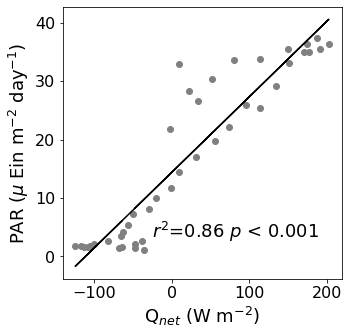

In [20]:
from scipy.stats import pearsonr

fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)
plt.scatter(qnet_clim.qnet,par_climatology.par,c='grey')

X=qnet_clim.qnet.values
Y = par_climatology.par.values

mask = ~np.isnan(X)&~np.isnan(Y)

print(pearsonr(X[mask],Y[mask])[0]**2)
print(pearsonr(X[mask],Y[mask])[1])

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
ax.plot(X,Y_pred,c='k')

ax.text(0.32,0.15,'$\it{r^2}$=0.86 $\it{p}$ < 0.001',transform=ax.transAxes)
ax.set_xlabel('Q$_{net}$ (W m$^{-2}$)')
ax.set_ylabel('PAR ($\mu$ Ein m$^{-2}$ day$^{-1}$)')

# plt.savefig('../results/figures/S_NHF_PAR.png',dpi=75,bbox_inches='tight')

# Regressions


In [21]:
# function to interpolate sat products to same timestep as chla

def interpolate(ts, datetime_index):
    x = pd.concat([ts, pd.Series(index=datetime_index)])
    return x.groupby(x.index).first().sort_index().fillna(method="ffill")[datetime_index]

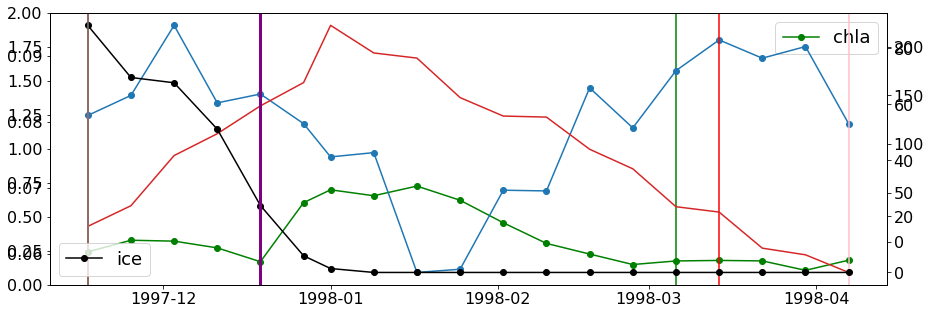

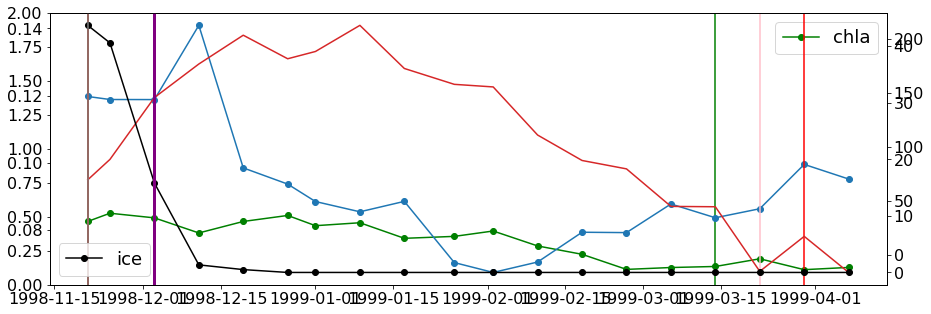

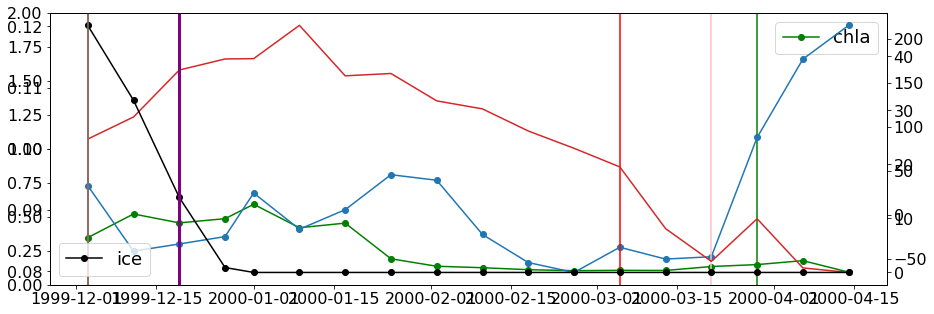

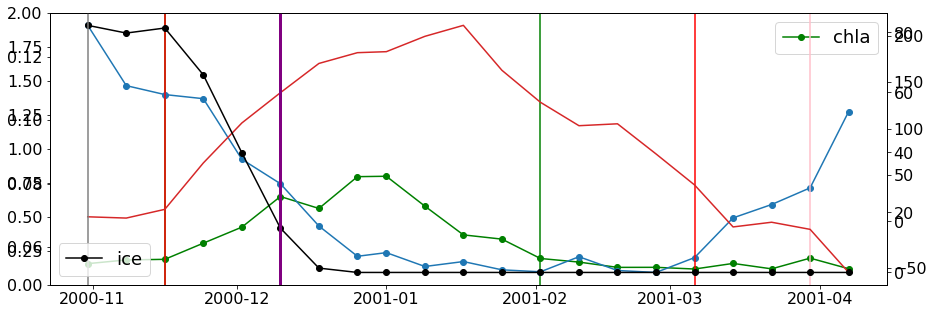

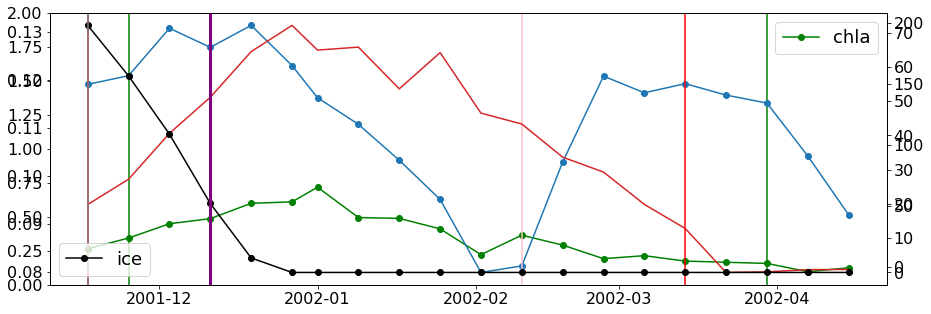

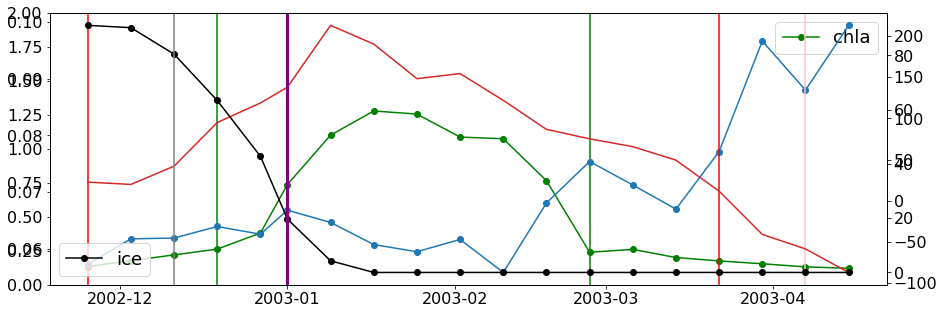

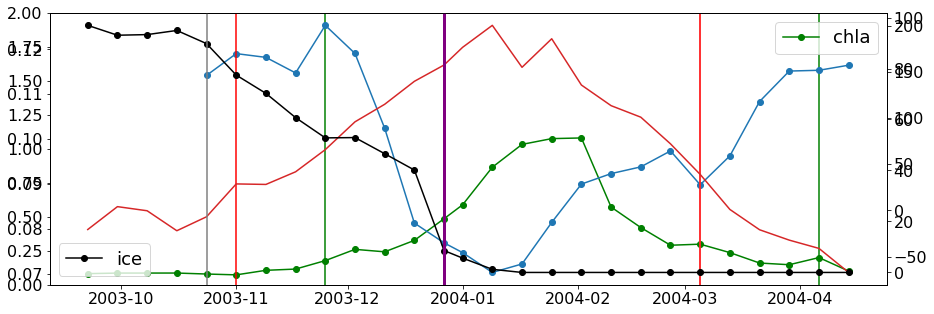

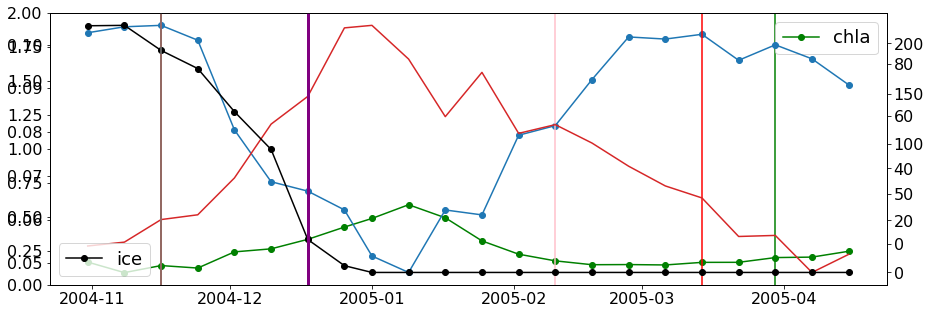

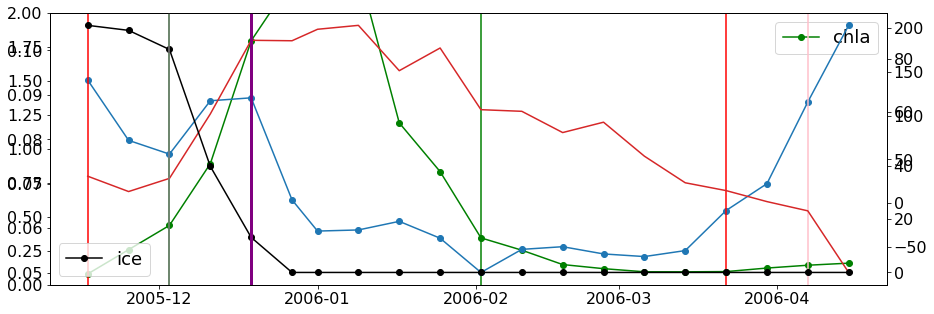

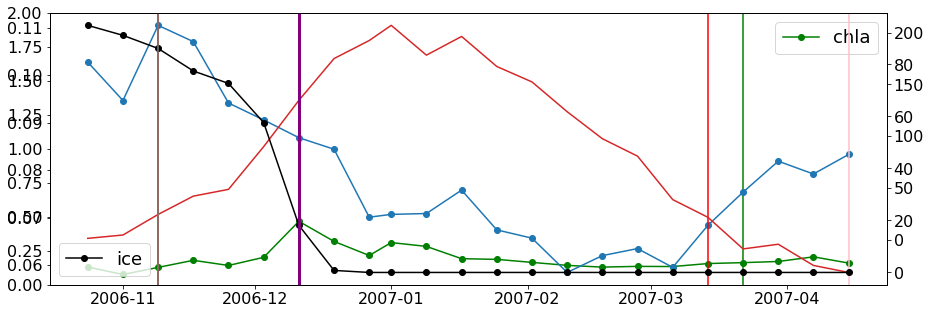

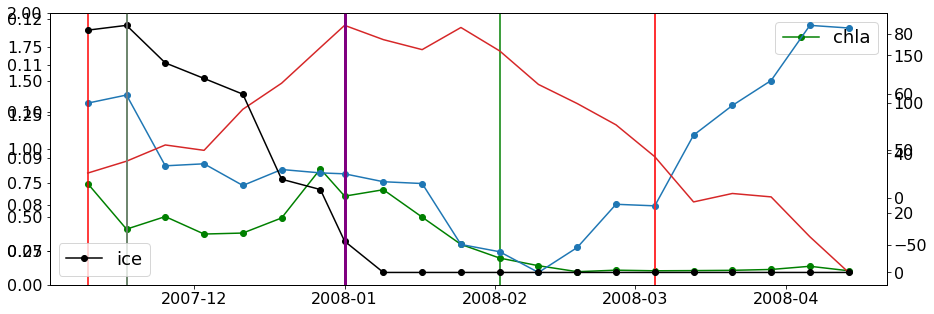

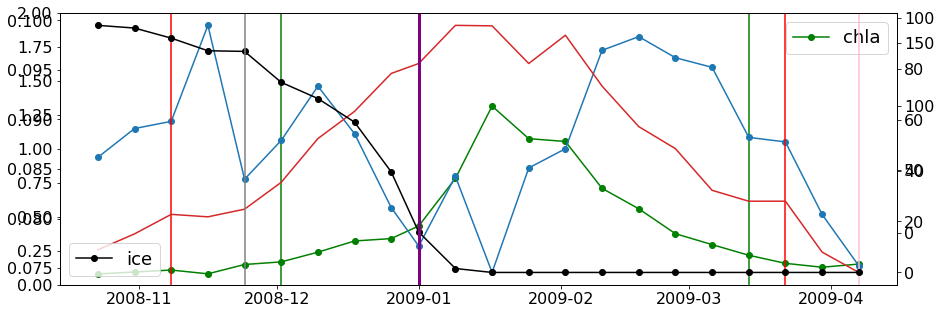

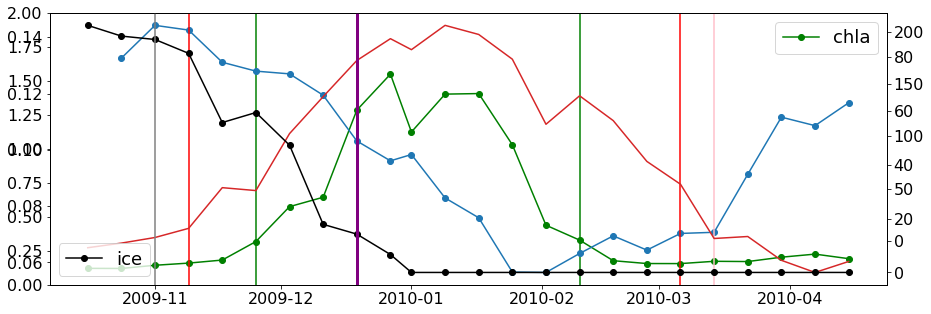

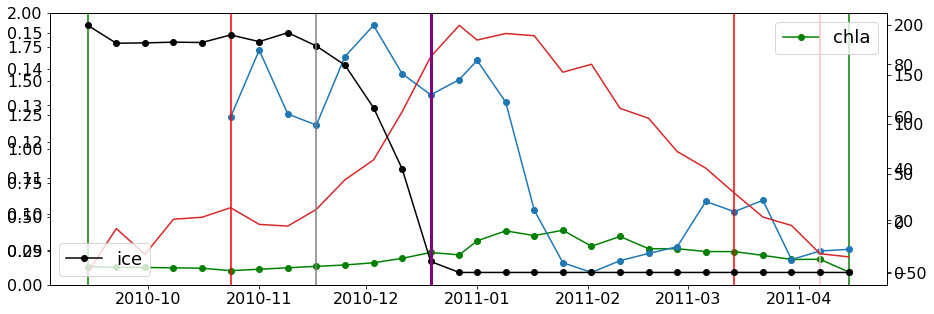

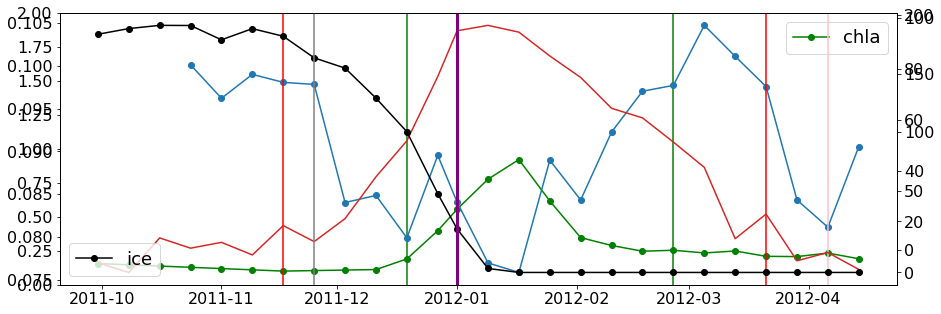

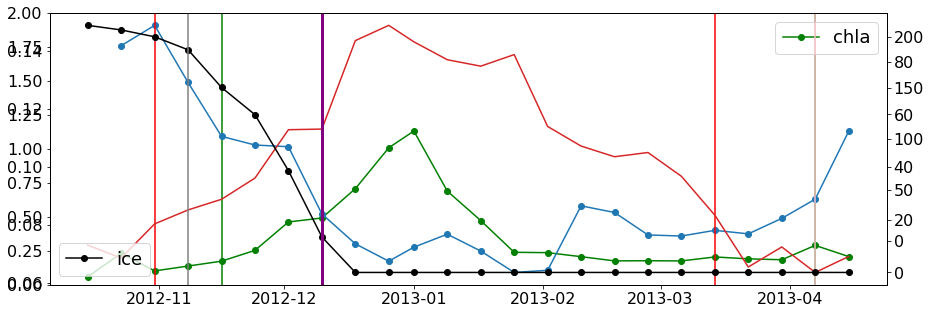

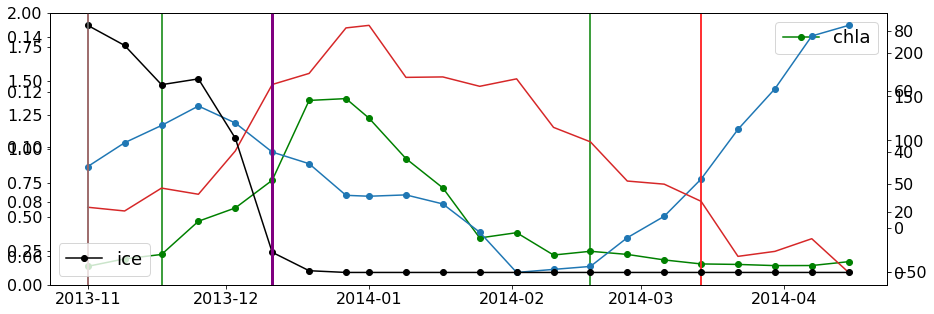

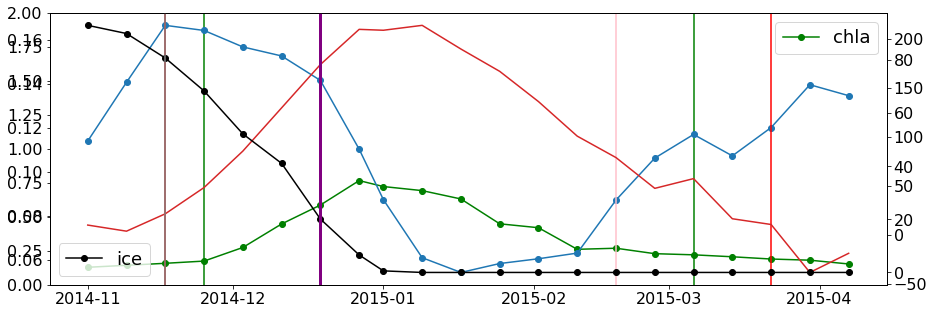

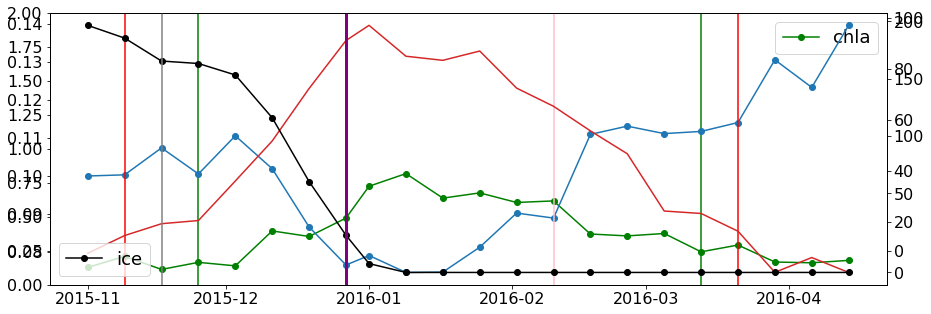

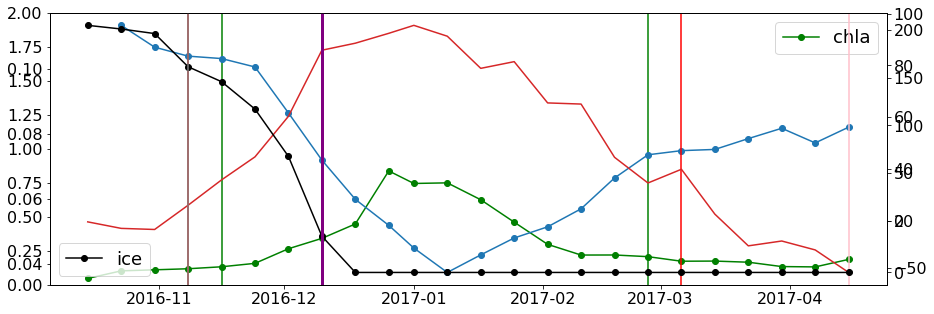

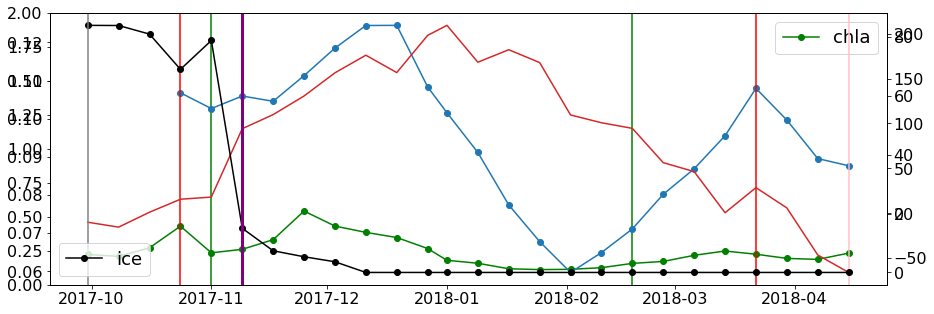

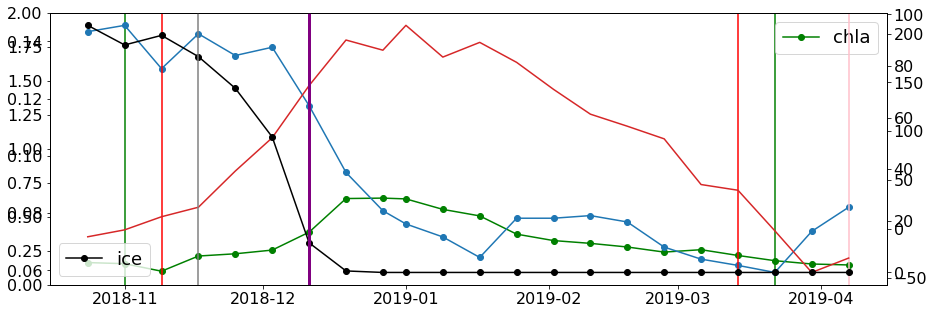

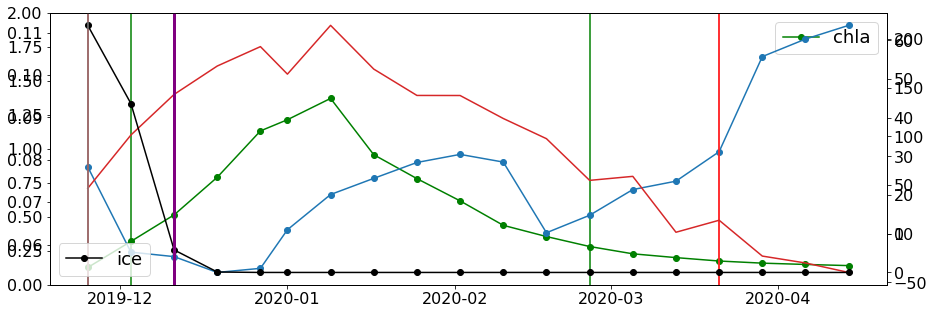

In [22]:
# Compute annual points for regressions, using 2002-2020


wind_decrease_day = np.ndarray(23)

wind_increase_day = np.ndarray(23)
ice_melt_day=np.ndarray(23)
ice_melt_end=np.ndarray(23)
max_magnitude=np.ndarray(23)
duration = np.ndarray(23)
int_chl= np.ndarray(23)
bloom_start=np.ndarray(23)
bloom_end=np.ndarray(23)
light_end=np.ndarray(23)

qnet_decrease=np.ndarray(23)
qnet_increase=np.ndarray(23)

zero_ice = np.ndarray(23)


for i,year in enumerate(np.arange(1997,2020)):
    midyear_start = '{}-09-01'.format(year)
    midyear_end = '{}-05-30'.format(year+1)
    
    
    fig,ax=plt.subplots(figsize=[15,5])

    chlds=satchl.sel(time=slice(midyear_start,midyear_end))
    chlds=chlds.interpolate_na(dim='time')  # deal with nans
    chlds=chlds.dropna(dim='time')
    
    maxchl = chlds.chlor_a.max().values
#     apex = np.array(x.time[x.chlor_a==x.chlor_a.max()])
    apex_ind = np.array(([chlds.chlor_a==chlds.chlor_a.max()])).argmax()
    prepeak_min = chlds.chlor_a[:apex_ind].min().values
    postpeak_min = chlds.chlor_a[apex_ind:].min().values
    prepeak_subset = chlds.isel(time=slice(0,apex_ind+1))
    postpeak_subset = chlds.isel(time=slice(apex_ind,len(chlds.chlor_a)))

    try:
        initiation = prepeak_subset.time[np.abs(prepeak_subset.chlor_a-(prepeak_min+(0.1*(maxchl-prepeak_min)))).argmin()].values
    
        termination = postpeak_subset.time[np.abs(postpeak_subset.chlor_a-(postpeak_min+(0.1*(maxchl-postpeak_min)))).argmin()].values
    except: continue


    length = (pd.Series(termination - initiation).dt.days)[0]


    ax.plot(chlds.time,chlds.chlor_a,marker='o',c='g',label='chla')

    ax.axvline(initiation,c='g')
    ax.axvline(termination,c='g')
    plt.ylim(0,2)
    plt.legend(loc=1)
    max_magnitude[i]=maxchl
    duration[i]=length
    bloom_start[i]=pd.Series(initiation).dt.dayofyear[0]
    bloom_end[i]=pd.Series(termination).dt.dayofyear[0]
    
    int_chl[i]=(prepeak_subset.chlor_a[(prepeak_subset.chlor_a.values<prepeak_min+(0.1*(maxchl-prepeak_min)))[-1]:].sum()+
                postpeak_subset.chlor_a[(postpeak_subset.chlor_a.values<postpeak_min+(0.1*(maxchl-postpeak_min)))[0]].sum())



    
    erads=era.sel(time=slice(midyear_start,midyear_end)).rolling(time=24*8).mean()
    erasub = interpolate(erads.tau.to_series(),chlds.time.to_series())

    termination=erasub.index.values[::-1][erasub[::-1]<0.09][0]


    wind_increase_day[i]=(pd.Series(termination).dt.dayofyear[0])
    ax2 = ax.twinx()
    ax2.plot(erasub.index,erasub,marker='o',c='tab:blue',label='wind')

    ax2.axvline(termination,c='pink')


    
    midyear_start = '{}-06-01'.format(year)
    midyear_end = '{}-05-30'.format(year+1)
    qnetsub = qnet.sel(time=slice(midyear_start,midyear_end)).rolling(time=24).mean()

    qnetsub = interpolate(qnetsub.to_series(),chlds.time.to_series())

    qnet_decrease[i]=pd.Series(qnetsub.index.values[::-1][qnetsub.values[::-1]>10][0]).dt.dayofyear
    qnet_increase[i]=pd.Series(qnetsub.index.values[qnetsub.values>10][0]).dt.dayofyear

    ax5=plt.twinx()

    ax5.axvline(pd.Series(qnetsub.index.values[::-1][qnetsub.values[::-1]>10][0]),c='r')
    ax5.axvline(pd.Series(qnetsub.index.values[qnetsub.values>10][0]),c='r')

    ax5.plot(qnetsub.index,qnetsub,c='tab:red')

    midyear_start = '{}-06-01'.format(year)
    midyear_end = '{}-05-30'.format(year+1)
    iceds=si_ds.sel(time=slice(midyear_start,midyear_end)).rolling(time=1).mean()
    iceds = interpolate(iceds.ice_conc.to_series(),chlds.time.to_series())
    
    max_ice = iceds.max()
    max_ind = np.array(([iceds==max_ice])).argmax()
    prepeak_min = iceds[:max_ind+1].min()
    postpeak_min = iceds[max_ind:].min()
    prepeak_subset = iceds.iloc[0:max_ind+1]
    postpeak_subset = iceds.iloc[max_ind:len(iceds)]

    termination=iceds.index[np.abs(iceds-85).argmin()]
    end_ice= iceds.index[np.abs(iceds-15).argmin()]
    zero_ice[i] = pd.Series(end_ice).dt.dayofyear
    ice_melt_day[i]=(pd.Series(termination).dt.dayofyear[0])

    ax3=ax.twinx()
    
    ax3.plot(iceds.index,iceds,marker='o',c='k',label='ice')
    ax3.axvline(termination,c='grey')
    ax3.axvline(end_ice,c='purple',lw=3)
    
    plt.legend(loc=3)
    
    
    ##########################
    
#     midyear_start = '{}-06-01'.format(year)
#     midyear_end = '{}-05-30'.format(year+1)
#     pards=par.sel(time=slice(midyear_start,midyear_end)).par
#     max_par = pards.max().values
#     max_ind = np.array(([pards==max_par])).argmax()
#     prepeak_subset = pards.isel(time=slice(0,max_ind+1))
#     postpeak_subset = pards.isel(time=slice(max_ind,len(pards)))
#     termination=postpeak_subset.time[(postpeak_subset.values<max_par*0.9)].values[0]
#     light_end[i]=np.array(pd.Series(termination).dt.dayofyear.values[0])

#     ax4=ax.twinx()
    
#     ax4.plot(pards.time,pards,marker='o',c='r',label='par')
# #     ax3.axvline(iceds.time[max_ind].values,c='grey')
#     ax4.axvline(termination,c='red')
    
    plt.legend(loc=3)
#     print(year)
#     print(maxchl)
    
    
    



In [23]:
bloom_start[bloom_start<280]=np.nan   # one bad data point
# np.nanmean(bloom_start)

0.16143160391910655
0.057378805966007466
0.6994651061641727
1.2428781412311883e-06


Text(0.05, 0.9, 'b')

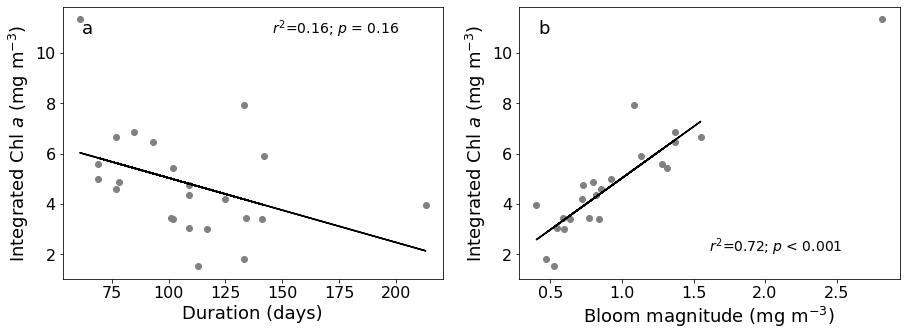

In [24]:
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
matplotlib.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(1,2,figsize=[15,5])

ax[0].scatter(duration,int_chl,c='grey')
X=duration
Y = np.array(
           int_chl)

mask = ~np.isnan(X)&~np.isnan(Y)

print(pearsonr(X[mask],Y[mask])[0]**2)
print(pearsonr(X[mask],Y[mask])[1])

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
ax[0].plot(X,Y_pred,c='k')


ax[1].scatter(max_magnitude,int_chl,c='grey')
X=max_magnitude
Y = (np.array(
           int_chl))


mask = ~np.isnan(X)&~np.isnan(Y)&(Y<10)

print(pearsonr(X[mask],Y[mask])[0]**2)
print(pearsonr(X[mask],Y[mask])[1])

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
ax[1].plot(X,Y_pred,c='k')

ax[0].set_xlabel('Duration (days)')
ax[0].set_ylabel('Integrated Chl $\it{a}$ (mg m$^{-3}$)')

ax[1].set_xlabel('Bloom magnitude (mg m$^{-3}$)')
ax[1].set_ylabel('Integrated Chl $\it{a}$ (mg m$^{-3}$)')

ax[0].text(0.55,0.9,'$\it{r^2}$=0.16; $\it{p}$ = 0.16',transform=ax[0].transAxes,fontsize=14)
ax[1].text(0.5,0.1,'$\it{r^2}$=0.72; $\it{p}$ < 0.001',transform=ax[1].transAxes,fontsize=14)

ax[0].text(0.05,0.9,'a',fontsize=18,transform=ax[0].transAxes)
ax[1].text(0.05,0.9,'b',fontsize=18,transform=ax[1].transAxes)



# plt.savefig('../results/figures/regression_intchl.png',dpi=150,bbox_inches='tight')

0.45252629892707474
0.0006030672731626062
0.3397578453175192
0.0044138229132983835
0.024406695495345406
0.47656214470801234
0.00038737585141984015
0.9289743508450562


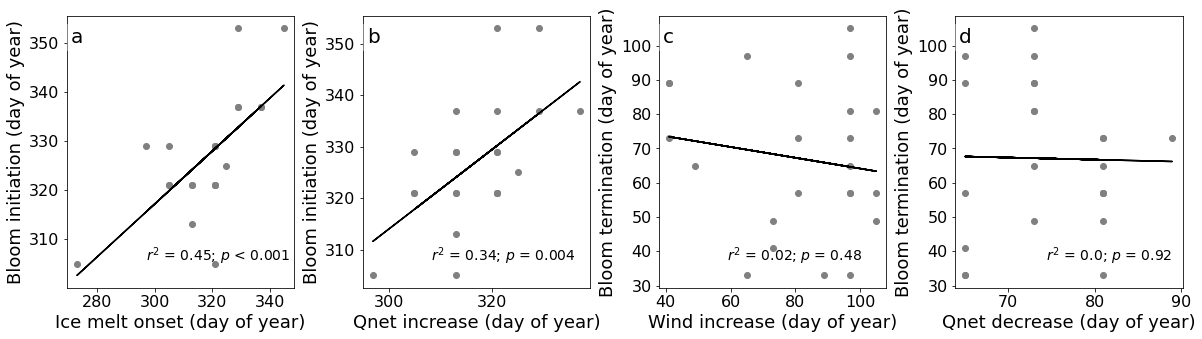

In [25]:
fig=plt.figure(figsize=[20,5])

ax1 = fig.add_subplot(141)
## Duration Regressions
bloom_start[bloom_start<280]=np.nan  
ax1.scatter(ice_melt_day,bloom_start,c='grey')


X=ice_melt_day
Y=bloom_start
mask = ~np.isnan(X)&~np.isnan(Y)

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)
print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))
plt.plot(X,Y_pred,c='k')
ax1.text(0.35,0.1,'$\it{r}^2$ = 0.45; $\it{p}$ < 0.001',fontsize=14,transform=ax1.transAxes)

ax1.set_xlabel('Ice melt onset (day of year)')
ax1.set_ylabel('Bloom initiation (day of year)')

ax2 = fig.add_subplot(142)

X=qnet_increase
Y=bloom_start



mask = ~np.isnan(X)&~np.isnan(Y)

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))

ax2.scatter(qnet_increase,bloom_start,c='Grey')

ax2.set_xlabel('Qnet increase (day of year)')
ax2.set_ylabel('Bloom initiation (day of year)')

ax2.plot(X,Y_pred,c='k')

ax2.text(0.3,0.1,'$\it{r^2}$ = 0.34; $\it{p}$ = 0.004',fontsize=14,transform=ax2.transAxes)



ax3 = fig.add_subplot(143)

X=wind_increase_day
Y=bloom_end

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])


mask = ~np.isnan(X)&~np.isnan(Y)


X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))

ax3.scatter(wind_increase_day,bloom_end,c='Grey')

ax3.set_xlabel('Wind increase (day of year)')
ax3.set_ylabel('Bloom termination (day of year)')

ax3.plot(X,Y_pred,c='k')

ax3.text(0.3,0.1,'$\it{r^2}$ = 0.02; $\it{p}$ = 0.48',fontsize=14,transform=ax3.transAxes)


ax4 = fig.add_subplot(144)

X=qnet_decrease
Y=bloom_end

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])


mask = ~np.isnan(X)&~np.isnan(Y)


X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))

ax4.scatter(qnet_decrease,bloom_end,c='Grey')

ax4.set_xlabel('Qnet decrease (day of year)')
ax4.set_ylabel('Bloom termination (day of year)')

ax4.plot(X,Y_pred,c='k')

ax4.text(0.4,0.1,'$\it{r^2}$ = 0.0; $\it{p}$ = 0.92',fontsize=14,transform=ax4.transAxes)


ax1.text(0.02,0.9,'a',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax2.text(0.02,0.9,'b',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax3.text(0.02,0.9,'c',transform=ax3.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax4.text(0.02,0.9,'d',transform=ax4.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))

plt.subplots_adjust(wspace=0.3)

# plt.savefig('../results/figures/supp_duration_drivers.png',dpi=150,bbox_inches='tight')

In [96]:
# era5 = xr.open_dataset(rootdir+'/results/processed_data/era5_winds.nc')
# era5 = era5.sel(longitude=0,latitude=-60)

In [39]:
icethick.thickness

<xarray.DataArray 'thickness' (date: 3498, y: 11, x: 70)>
[2693460 values with dtype=float64]
Coordinates:
    time     (date) int64 0 1 2 3 4 5 6 7 ... 3491 3492 3493 3494 3495 3496 3497
  * date     (date) datetime64[ns] 2010-06-01 2010-06-02 ... 2019-12-31
    lon      (y, x) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 6.5 7.5 8.5 9.5
    lat      (y, x) float64 -69.5 -69.5 -69.5 -69.5 ... -59.5 -59.5 -59.5 -59.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

(-63.0, -59.0)

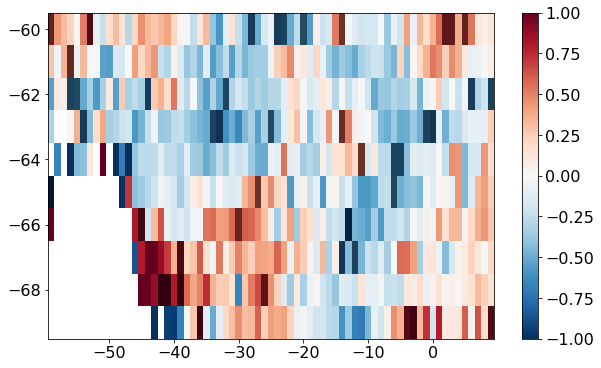

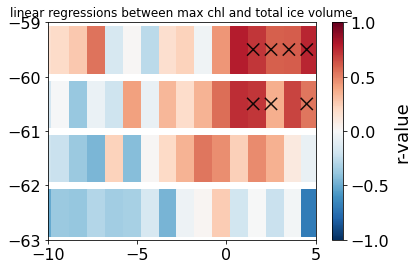

In [27]:
icethick = xr.open_dataset('../data/seaice/sea_ice_thickness.nc')

#alternative chl-max calculation

satchl = xr.open_dataset('../data/chl/CCI_ALL-v5.0-MONTHLY.nc')
import xesmf as xe

ds_out = xe.util.grid_2d(-60,10,1,-70,-59,1)


regridder = xe.Regridder(satchl, ds_out, 'bilinear')
chl_out = regridder(satchl.chlor_a)

chl_out['lon']=ds_out.lon
chl_out['lat']=ds_out.lat

import numpy as np
# use a different method

max_magnitude_all=np.zeros([9,70,11])
# duration = np.ndarray(9)
# int_chl=np.ndarray(9)

for i,year in enumerate(np.arange(2011,2020)):
    for j in range(len(chl_out.x[:70])):
        for k in range(len(chl_out.y[:11])):
            
            midyear_start = '{}-06-01'.format(year)
            midyear_end = '{}-05-01'.format(year+1)
            chlds=chl_out.sel(time=slice(midyear_start,midyear_end)).isel(x=j,y=k)
            chlds=chlds.interpolate_na(dim='time')  # deal with nans

            maxchl = chlds.max()

            max_magnitude_all[i,j,k]=maxchl
            
max_magnitude_all= max_magnitude_all.transpose(0,2,1)
iceind=(icethick.resample(date='Y').sum().thickness)[1:,:,:]

from scipy.stats import pearsonr
regression_ice_chl = np.zeros([11,70])
pvalue_ice_chl = np.zeros([11,70])


for j in range(11):
    for k in range(70):
        X = iceind[:,j,k].values
        Y = max_magnitude_all[:,j,k]
        mask = ~np.isnan(X)&~np.isnan(Y)
        X= X[mask]
        Y= Y[mask]
#         print(X)
        
        try:
            regression_ice_chl[j,k] =  pearsonr(X,Y)[0]
            pvalue_ice_chl[j,k] =  pearsonr(X,Y)[1]

# #             print(pearsonr(X,Y)[0]**2)
        except: 
            regression_ice_chl[j,k] = np.nan
            pvalue_ice_chl[j,k] = np.nan
        
        

plt.figure(figsize=[10,6])
xx,yy = np.meshgrid(icethick.lon[1,:],icethick.lat[:,1])
# xx,yy = np.meshgrid(np.arange(1,71),np.arange(1,12))
plt.pcolormesh(xx,yy,regression_ice_chl,cmap=plt.cm.RdBu_r,vmin=-1,vmax=1, shading='flat')
plt.colorbar()
# plt.scatter(xx,yy,c=np.where(pvalue_ice_chl<0.1,1,np.nan),marker='*',alpha=0.9, cmap=plt.cm.Greys_r)
plt.pcolormesh(xx,yy,np.where(pvalue_ice_chl<0.1,1,np.nan),hatch='/',alpha=0.5, cmap=plt.cm.Greys_r,shading='flat')

plt.figure()

plt.title('linear regressions between max chl and total ice volume',fontsize=12)
plt.scatter(xx,yy,c=regression_ice_chl,s=2150,marker='s',cmap=plt.cm.RdBu_r)
cbar=plt.colorbar()
cbar.set_label('r-value')
plt.scatter(xx,yy,c=np.where(pvalue_ice_chl<0.1,1,np.nan),marker='x',alpha=0.9,s=150,cmap=plt.cm.Greys_r)
plt.xlim(-10,5)
plt.ylim(-63,-59)


In [28]:
mld1=float4467.mld.resample(time='Y').max()[1:-2]
mld2=float4397.mld.resample(time='Y').max()[:-1]

In [29]:
# compute seasonal chlmax
chlmax4467=[]
for i,year in enumerate(np.arange(2015,2018)):


    midyear_start = '{}-06-01'.format(year)
    midyear_end = '{}-05-30'.format(year+1)
    subset=float4467.chla.sel(time=slice(midyear_start,midyear_end))[:20,:].mean(dim='depth')
    chlmax4467.append(subset.max().values)

    
chlmax4397=[]
for i,year in enumerate(np.arange(2015,2020)):


    midyear_start = '{}-06-01'.format(year)
    midyear_end = '{}-05-30'.format(year+1)
    subset=float4397.chla.sel(time=slice(midyear_start,midyear_end))[:20,:].mean(dim='depth')

    chlmax4397.append(subset.max().values)

In [30]:
chl_all = np.concatenate([chlmax4467,chlmax4397])
mld_all = np.concatenate([mld1,mld2])
print(mld_all)

[145. 134. 122. 146. 130. 126. 127. 147.]


In [31]:
mld_sortedbyyear=np.array([145,146,134,130,122,126,127,147])

In [59]:
import gsw
zonal_distance=gsw.distance((0.5,1.5),(-60,-60))

In [60]:
meridional_distance=gsw.distance((0.5,0.5),(-60,-61))

In [74]:
iceindA= np.repeat((((iceind[:,-3:,-10:-5].values/100).sum(1)*zonal_distance).sum(1)*meridional_distance),2)[-10:-1]/1e12
iceindA=np.delete(iceindA,6) # remove year that doesnt have a corressponding MLD estimate
iceindA

#/1e4     # select box of interest


array([7.33500462, 7.33500462, 6.05595304, 6.05595304, 4.88366083,
       4.88366083, 5.19180085, 6.44473463])

0.601920695832662
0.02363833399944325
0.8456144155461929
0.0012234167919019801
0.8456144155461924
0.7272735582776609
0.0034780457105358644


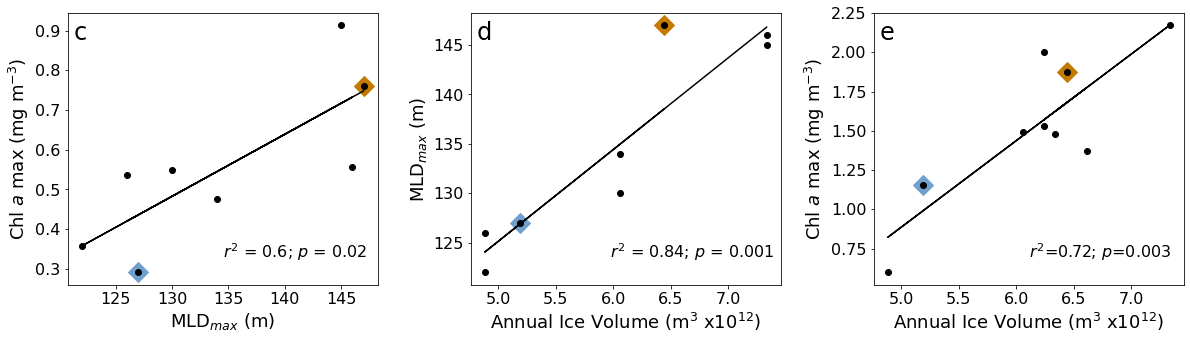

In [80]:
# Amplitude regressions
# from statsmodels.nonparametric.kernel_regression import KernelReg


fig=plt.figure(figsize=[20,5])

ax1 = fig.add_subplot(131)

years=[2016,2017,2018,2016,2017,2018,2019,2020]


X=mld_all
Y = np.array(
            chl_all)

mask = ~np.isnan(X)&~np.isnan(Y)

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))

# ax1.set_title('ARGO floats')
ax1.scatter(mld_all[-1],chl_all[-1],s=200,color=orange,marker='D')
ax1.scatter(mld_all[-2],chl_all[-2],s=200,color=lightblue,marker='D')

cs=ax1.scatter(X,Y,c='k')
# for i, txt in enumerate(years):
#     ax1.annotate(txt, (X[i], Y[i]))
# cs=ax1.scatter(X,Y,c=iceindA,cmap=)

ax1.plot(X,Y_pred,c='k',label='r2=0.62')
ax1.set_xlabel('MLD$_{max}$ (m)')
ax1.set_ylabel('Chl $\it{a}$ max (mg m$^{-3}$)')
ax1.text(0.5,0.1,'$\it{r^2}$ = 0.6; $\it{p}$ = 0.02',fontsize=16,transform=ax1.transAxes)

ax2=fig.add_subplot(132)


# iceindA= np.repeat(iceind[:,-3:,-10:-5].values.sum(1).sum(1),2)[-10:-1]/1e4
# iceindA=np.delete(iceindA,6)
years=[2016,2016,2017,2017,2018,2018,2019,2020]

Y=np.array(mld_sortedbyyear)
X = np.array(iceindA)

mask = ~np.isnan(X)&~np.isnan(Y)

X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])


linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
print(linear_regressor.score(X,Y))


# ax2.set_title('ARGO floats')

ax2.scatter(iceindA[-1],mld2[-1],s=200,color=orange,marker='D')
ax2.scatter(iceindA[-2],mld2[-2],s=200,color=lightblue,marker='D')
cs=ax2.scatter(iceindA,mld_sortedbyyear,c='k')

ax2.plot(X,Y_pred,c='k',label='r$^2$=0.72, p=0.003')
ax2.set_xlabel('Annual Ice Volume (m$^3$ x10$^{12}$)' )
ax2.set_ylabel('MLD$_{max}$ (m)')

ax2.text(0.45,0.1,'$\it{r^2}$ = 0.84; $\it{p}$ = 0.001',transform=ax2.transAxes,fontsize=16)

ax3=fig.add_subplot(133)

X = (((iceind[:,-3:,-10:-5].values/100).sum(1)*zonal_distance).sum(1)*meridional_distance)/1e12

Y = max_magnitude_all[:,-3:,-10:-5].mean(1).mean(1)*2

mask = ~np.isnan(X)&~np.isnan(Y)
X= X[mask]
Y= Y[mask]

ax3.scatter(X[-1],Y[-1],s=200,color=orange,marker='D')
ax3.scatter(X[-2],Y[-2],s=200,color=lightblue,marker='D')
ax3.scatter(X,Y,c='k')

X=X.reshape(-1,1)
Y=Y.reshape(-1,1)

print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])


linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
# print(linear_regressor.score(X,Y))


ax3.plot(X,Y_pred,c='k')
ax3.text(0.5,0.1,'$\it{r^2}$=0.72; $\it{p}$=0.003',transform=ax3.transAxes,fontsize=16)
ax3.set_title('')

ax3.set_ylabel('Chl $\it{a}$ max (mg m$^{-3}$)')
ax3.set_xlabel('Annual Ice Volume (m$^3$ x10$^{12}$)')

ax1.text(0.02,0.9,'c',transform=ax1.transAxes,fontsize=24,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax2.text(0.02,0.9,'d',transform=ax2.transAxes,fontsize=24,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax3.text(0.02,0.9,'e',transform=ax3.transAxes,fontsize=24,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))


plt.subplots_adjust(wspace=0.3)
plt.savefig('../results/figures/figure2b.png',dpi=150,bbox_inches='tight')

In [34]:
# Additional regression showing chl-a and n2 relationship
ds4467=xr.open_dataset('../data/argo/argo4467.nc')
ds4397=xr.open_dataset('../data/argo/argo4397.nc')

# compute seasonal n2max
n2max4467=[]
for i,year in enumerate(np.arange(2015,2018)):


    midyear_start = '{}-12-01'.format(year)
    midyear_end = '{}-02-28'.format(year+1)
    subset=ds4467.n2.sel(time=slice(midyear_start,midyear_end))[:200,:].mean(dim='depth')
    n2max4467.append(subset.max().values)

    
n2max4397=[]
for i,year in enumerate(np.arange(2015,2020)):


    midyear_start = '{}-12-01'.format(year)
    midyear_end = '{}-02-28'.format(year+1)
    subset=ds4397.n2.sel(time=slice(midyear_start,midyear_end))[:200,:].mean(dim='depth')

    n2max4397.append(subset.max().values)



In [35]:
summern2= np.concatenate([n2max4467,n2max4397[:]]).squeeze()
chl_all = np.concatenate([chlmax4467,chlmax4397])
mld_all = np.concatenate([mld1,mld2])

0.601920695832662
0.02363833399944325
0.6019206958326616
0.47235891861178586
0.05964297300264315
0.47235891861178536


Text(0.02, 0.9, 'b')

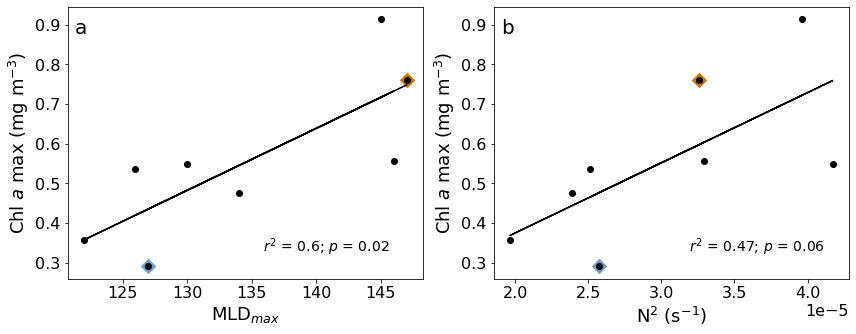

In [36]:
fig=plt.figure(figsize=[14,5])

ax1 = fig.add_subplot(121)

years=[2016,2017,2018,2016,2017,2018,2019,2020]


X=mld_all
Y = np.array(
            chl_all)


mask = ~np.isnan(X)&~np.isnan(Y)



X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)
print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])

linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
print(linear_regressor.score(X,Y))


# ax1.set_title('ARGO floats')
ax1.scatter(mld_all[-1],chl_all[-1],s=100,color=orange,marker='D')
ax1.scatter(mld_all[-2],chl_all[-2],s=100,color=lightblue,marker='D')

cs=ax1.scatter(X,Y,c='k')
# for i, txt in enumerate(years):
#     ax1.annotate(txt, (X[i], Y[i]))
# cs=ax1.scatter(X,Y,c=iceindA,cmap=)

ax1.plot(X,Y_pred,c='k')
ax1.set_xlabel('MLD$_{max}$')
ax1.set_ylabel('Chl $\it{a}$ max (mg m$^{-3}$)')
ax1.text(0.55,0.1,'$\it{r^2}$ = 0.6; $\it{p}$ = 0.02',fontsize=14,transform=ax1.transAxes)

ax2 = fig.add_subplot(122)

years=[2016,2017,2018,2016,2017,2018,2019,2020]


X=summern2
Y = np.array(
            chl_all)


mask = ~np.isnan(X)&~np.isnan(Y)



X= X[mask].reshape(-1,1)
Y =Y[mask].reshape(-1,1)
print(pearsonr(X.flatten(),Y.flatten())[0]**2)
print(pearsonr(X.flatten(),Y.flatten())[1])


linear_regressor = LinearRegression()
linear_regressor.fit(X,Y)
Y_pred = linear_regressor.predict(X)
print(linear_regressor.score(X,Y))


# ax1.set_title('ARGO floats')
ax2.scatter(summern2[-1],chl_all[-1],s=100,color=orange,marker='D')
ax2.scatter(summern2[-2],chl_all[-2],s=100,color=lightblue,marker='D')

cs=ax2.scatter(X,Y,c='k')
# for i, txt in enumerate(years):
#     ax1.annotate(txt, (X[i], Y[i]))
# cs=ax1.scatter(X,Y,c=iceindA,cmap=)

ax2.plot(X,Y_pred,c='k')
ax2.set_xlabel('N$^{2}$ (s$^{-1}$)')
ax2.set_ylabel('Chl $\it{a}$ max (mg m$^{-3}$)')
ax2.text(0.55,0.1,'$\it{r^2}$ = 0.47; $\it{p}$ = 0.06',fontsize=14,transform=ax2.transAxes)


ax1.text(0.02,0.9,'a',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))
ax2.text(0.02,0.9,'b',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.4))


# plt.savefig('../results/figures/supp_chla_drivers.png',dpi=150,bbox_inches='tight')